In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

**SOURCE**

https://theaisummer.com/distributed-training-pytorch/
여기 보고함!

look at https://www.youtube.com/watch?v=3XUG7cjte2U&t=1832s

https://www.youtube.com/watch?v=TibQO_xv1zc&t=2128s  ==> better

https://www.youtube.com/watch?v=RQfK_ViGzH0&t=110s ==> 이거는 어려워서 필요없을수도


제일 중요한 tutorial (이것보고 밑에 작성) : 
https://tutorials.pytorch.kr/beginner/dist_overview.html

(github version of this : https://github.com/pytorch/tutorials/blob/master/beginner_source/dist_overview.rst) 



# Prelude. Basic Stuff

In [2]:
import torch

torch.cuda.device_count() #see how many gpus I can use

2

# 그냥 https://theaisummer.com/distributed-training-pytorch/ 여기보고 따라하기!! 여기서 너무 설명 잘해줘서. 이걸로 1. 2.둘다 하면 될듯?
(with https://medium.com/codex/a-comprehensive-tutorial-to-pytorch-distributeddataparallel-1f4b42bb1b51 and pytorch tutorial as theory)

# 0. single GPU, DP 공통 샘플 코드
우리는 위의 AI summer (https://theaisummer.com/distributed-training-pytorch/)  것을 써서 할 것이다. 따라서, DP, DDP 둘다 공통으로 사용하는 코드를 쓸 것이다

https://github.com/The-AI-Summer/pytorch-ddp
위에 blog의 코드들이 있다!


# 아니다! 밑의 코드는 single GPU, DP만 공통이고, DDP 는 조금 다르다 ==> 이것은 그래서 chapter numbering을 조금 다르게 해야할듯?

# 1. Single GPU (즉, default)
(사실, DP 도 여기코드를 거의 그대로 쓴다 (뒤에 보면 나올 것)

In [3]:
#common imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os

/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/connectome/dyhan316/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
#create dataloader
def create_data_loader_cifar10():
    transform = transforms.Compose([
       transforms.RandomCrop(32),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    batch_size = 256 #8192
    
    #dataset들 정의 (trainset, testset) from pre-existing CIFAR10
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    
    #dataloader들 정의 (train_loader, test_loader)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=10, pin_memory=True)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=10)
    return trainloader, testloader 
    

In [5]:
#training loop 하는 것을 만들기
def train(net, trainloader):
    print("started training ...")
    
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(),lr = 0.001, momentum = 0.9)
    epochs = 1 #i.e. only one epoch 만 할것
    num_of_batches = len(trainloader) #number of batches
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            images, labels = inputs.cuda(), labels.cuda() #move to cuda
            
            #zero the parameter gardients
            optimizer.zero_grad()
            
            #forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #print statistics
            running_loss += loss.item() #.item because detach grad
            
        
        print(f'[Epoch {epoch + 1}/{epochs}] loss: {running_loss / num_of_batches:.3f}')
    print("Finished Traning")

In [6]:
#testing loop 만들기
def test(net, PATH,testloader): #PATH : 어디있는 state_dict를 load할지 
    net.load_state_dict(torch.load(PATH)) #load the state_dict 
    
    
    correct = 0 #correct counter
    total = 0 #total counter
    
    #since not training, set no_grad
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images, labels = images.cuda(), labels.cuda() #move to gpu
            
            #calculate output
            outputs = net(images)
            
            #get loss value and update the number of correct/total 
            _, predicted = torch.max(outputs.data, 1) #maximum 인 것이 나의 prediction
            total += labels.size(0) #256개의 batch 여서 256
                    #i.e. torch.size([256]) => 256 으로 빼내기 (256: batch size btw)
            correct += (predicted == labels).sum().item() #i.e. array같은 bool array, sum, then itemize
            
        acc = 100 * correct//total #// : floor division
        print(f'Accuracy of the network on the 10000 test images: {acc} %')

In [7]:
#실제로 돌리기 (시간 많이 걸리니 주의!)
start = time.time() 

PATH = './cifar_net_single_gpu.pth' #single gpu 의 결과 save pth (save path) 
trainloader, testloader = create_data_loader_cifar10()

net = torchvision.models.resnet50(pretrained = False).cuda() #이미 있는 model 가져오기

start_train = time.time()

#run training loop
train(net, trainloader)

end_train = time.time() 

#save 
torch.save(net.state_dict(), PATH) #PATH에 state_dict저장해놓기

#test
test(net, PATH, testloader) #path : 어디에있는 것을 불러올지 말함 

end = time.time()

seconds = (end - start)
seconds_train = (end_train - start_train)

print(f"Total elapsed time: {seconds:.2f} seconds, \  Train 1 epoch {seconds_train:.2f} seconds")

Files already downloaded and verified
Files already downloaded and verified


/home/connectome/dyhan316/.conda/envs/CHA_ML/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


started training ...
[Epoch 1/1] loss: 2.364
Finished Traning
Accuracy of the network on the 10000 test images: 26 %
Total elapsed time: 30.18 seconds, \  Train 1 epoch 23.23 seconds


# 2. DP (DataParllel) 로 여러개 돌리기
(still slower than DDP)

* batch size is divided across the number of workers
    * Each replica handles a portion of the batch (batch_size / gpus)
* only a few changes to code needed
*  In each forward pass, the module is replicated on each GPU, which is a significant overhead
* During the backwards pass, gradients from each replica are summed into the original module.

ONLY ONE CHANGE IN CODE NEEDED! 

> ```net = nn.DataParallel(net)```

In [8]:
#net 정의하는 파트만 바뀌면 된다!
#실제로 돌리기 (시간 많이 걸리니 주의!)
start = time.time() 

PATH = './cifar_net_dp.pth' #single gpu 의 결과 save pth (save path) 
trainloader, testloader = create_data_loader_cifar10()

net = torchvision.models.resnet50(pretrained = False).cuda() #이미 있는 model 가져오기

#######THE PART THAT WAS CHANGED######
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
    print("We will use : {} gpus".format(torch.cuda.device_count()))

start_train = time.time()

#run training loop
train(net,trainloader)

end_train = time.time() 

#save 
torch.save(net.state_dict(), PATH) #PATH에 state_dict저장해놓기

#test
test(net, PATH, testloader) #path : 어디에있는 것을 불러올지 말함 

end = time.time()

seconds = (end - start)
seconds_train = (end_train - start_train)

print(f"Total elapsed time: {seconds:.2f} seconds, \ Train 1 epoch {seconds_train:.2f} seconds")

Files already downloaded and verified
Files already downloaded and verified
We will use : 2 gpus
started training ...
[Epoch 1/1] loss: 2.365
Finished Traning
Accuracy of the network on the 10000 test images: 25 %
Total elapsed time: 41.56 seconds, \ Train 1 epoch 35.34 seconds


# ===ASK ASK AKS===
**위에 돌려보면**, `nvidia-smi` 에서 볼 수 있듯이, gpu하나가 아닌 두개를 쓰게 된다!

단, 여전히 그냥 하나만 쓰는 것보다는 느리다! 

**BUT** : batchsize= 256에서는 gpu 하나만 쓰는게 더 빠르지만, batchsize = 8192 에서는 DP가 더 빠름!

* cpu/hard-disk bottleneck 때문에 그런 듯!
    * 즉, batchsize가 작을때는, gpu하나에서만 돌려도 cuda core이 충분하기때문에, gpu를 두개로 늘림으로서 얻는 performance gain이 없다 (여전히 모든 batch가 parllel하게 돌아감)
    * 하지만, batchsize가 커졌으면, DP의 경우 batch를 분산해서 보내기 때문에, increaed gpu 갯수로 인해서 증가하는 performance가 cpu/hard-disk bottleneck 로 인해 감소하는 performance보다 크다. 따라서, 더 빠른 듯?
    
**ASK IF THIS IS TRUE**


## ===ASK ASK AKS ===
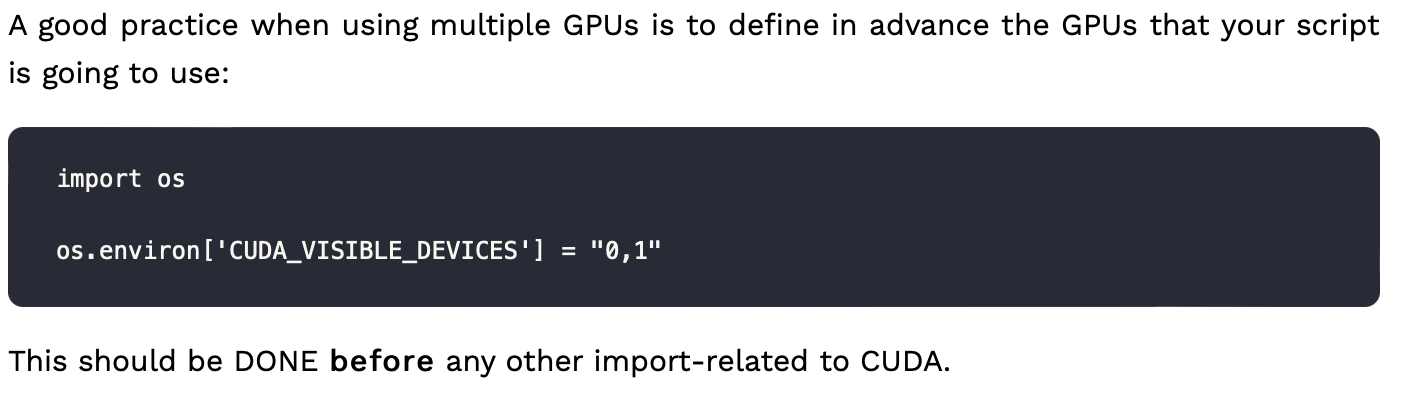



In [9]:
os.environ['CUDA_VISIBLE_DEVICES']

'5,6'



## QUESTION 
**why DDP instead of DP?**

https://pytorch.org/docs/stable/notes/cuda.html#cuda-nn-ddp-instead

위의 링크보고 **수영쌤 답변 듣고 답변 적기!!**

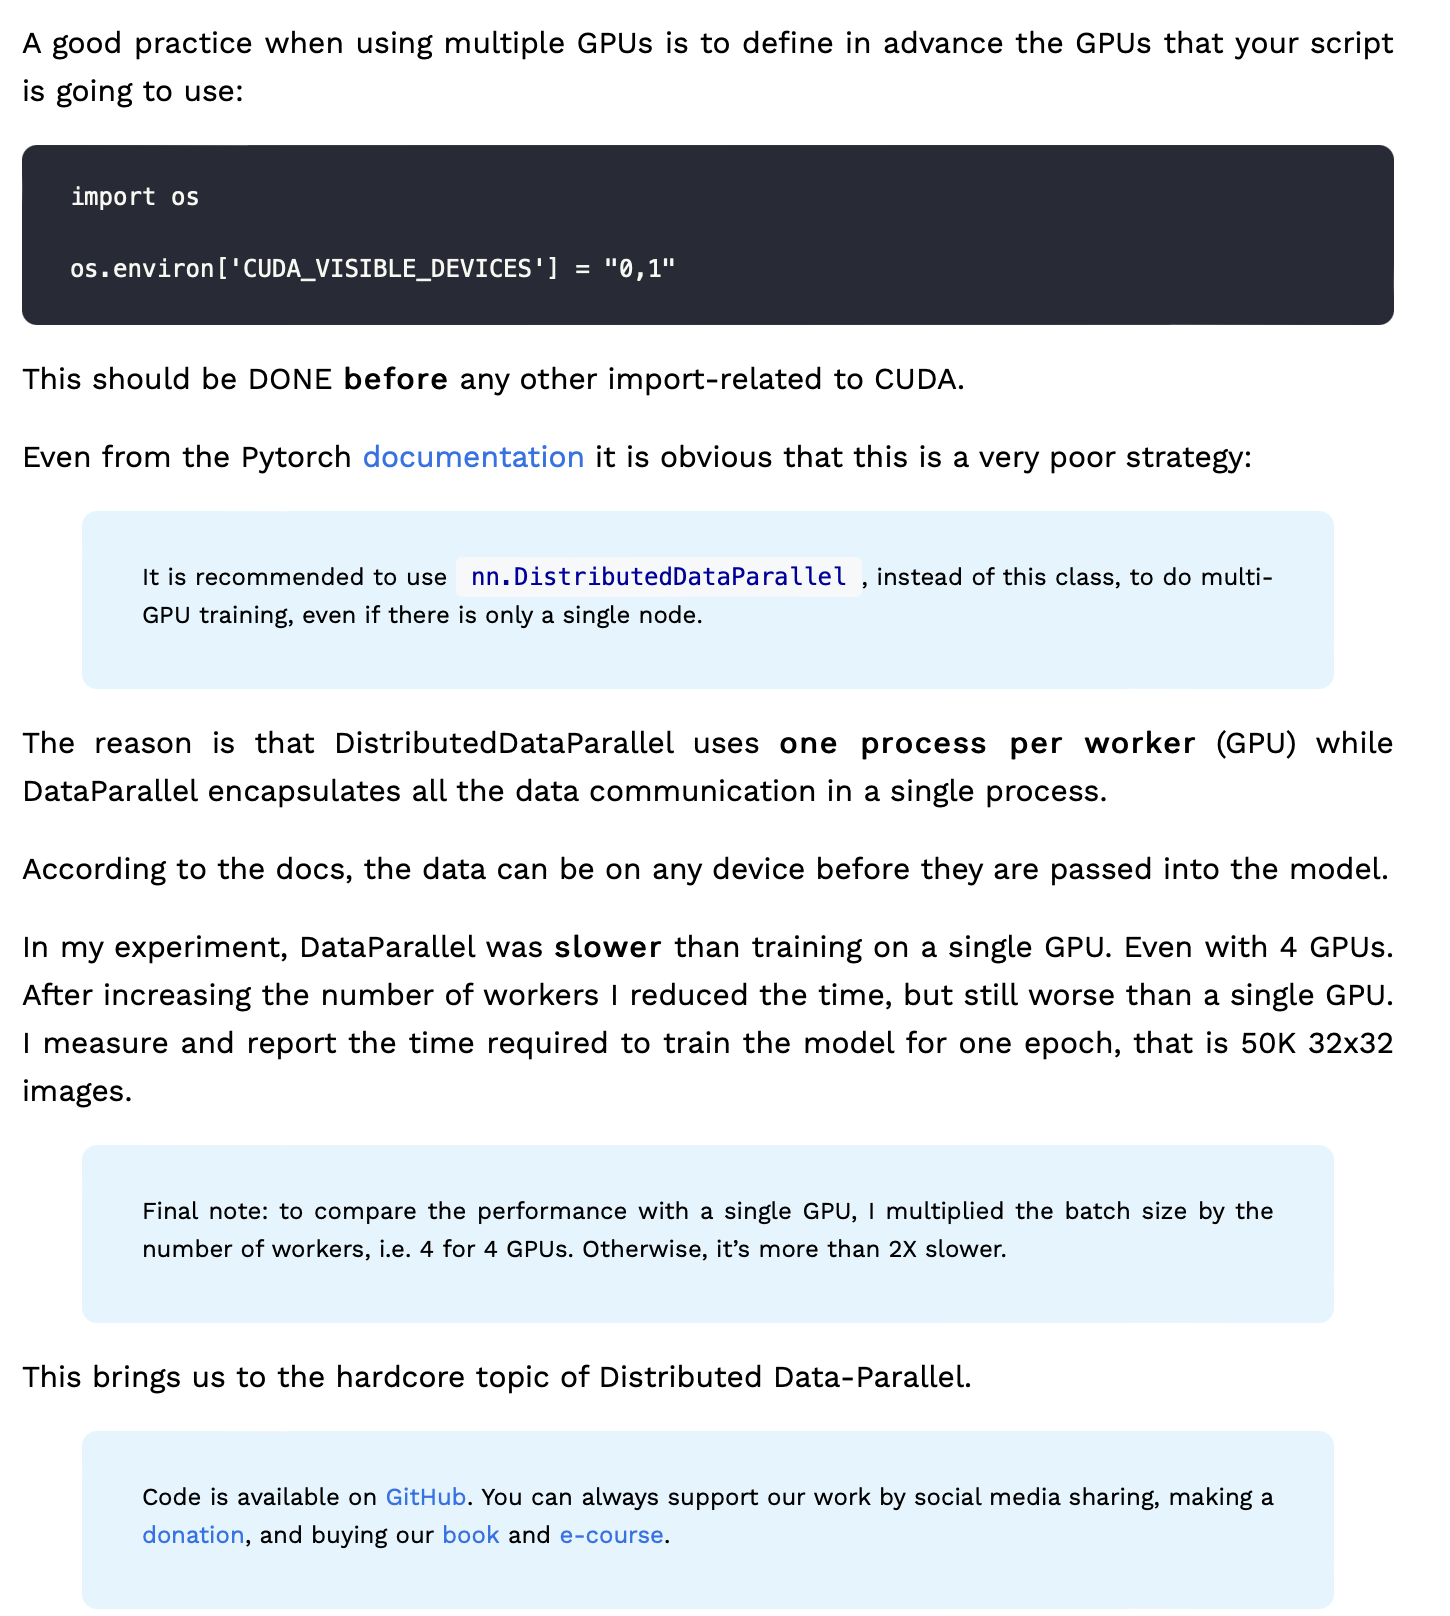

위의 것도 있는데, 질문하기

# 3. DDP (DistributedDataParallel)로 더 efficiently 여러개 돌리기
* (DP와 달리) multi-process 이다 (DP : single-process)
* can do single or multi-machien training (i.e. many cpus/nodes)


**why DDP > DP?**
* each GPU is handled by a process (?). Parameters are never broadcasted b/w processes, only gradients
    * 즉, **the module is replicated on each machine and each device**
    * forward pass : each GPU processes the data and computes its gradient locally
    * backward pass : gradients from each node are AVERAGED (in an all-reduced method, to increase parallism)
    * update : averaged gradients are sent to all the other nodes and they collectively do an update


=> 즉, ((a+b)+c)+d 가 아닌 (a+b)+(c+d) 로 해서 더 빠르다!



=====

## 3.1. Step1 : Initialize the distributed learning preocesses

**이 파트 하나도 모르겠다..ㅋㅋㅋ**



**ASK**
* what is 'distributed backend' in the comment below?
    * 밑에 있는 dist_url 은 뭐고 왜 설정해주는 거지?
* `#only works with torch.distributed.launch // torch.run` 이거는 뭐지...?



**정리하기**
* local_rank, world_size등등이 뭔지 적자 : 
    * https://shivgahlout.github.io/2021-05-18-distributed-computing/
    * https://stackoverflow.com/questions/58833652/what-does-local-rank-mean-in-distributed-deep-learning
    

In [32]:
print(os.getenv("RANK"), os.getenv("WORLD_SIZE"), os.getenv("LOCAL_RANK"))

None None None


In [19]:
def init_distributed():
    # Initializes the distributed backend which will take care of synchronizing nodes/GPUs
    dist_url = "env://" #default (?) 이건 뭐지
    
    #only works with torch.distributed.launch // torch.run
    rank = int(os.environ['RANK'])
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])
    
    ##ASK : dist를 어디서 정의해준 적 없는데, 갑자기 저렇게 `.init_process_group`
    #을 설정하는 것은 뭐지?
    dist.init_process_group(
        backend = "nccl",
        init_method = dist_url,
        world_size = world_size,
        rank = rank)

    ##ASK the things below
    #this will make all .cuda() calls work properly
    torch.cuda.set_device(local_rank)
    
    
    ##ASK WHAT BELOW IS
    #sychronizes all the threads to reach this point before moving on
    dist.barrier()

## 3.2. Step2 : Wrap the model using DDP and SyncBatchNorm

`net` 이라는 함수 정의된 것이 있으면, 밑의 두가지를 wrapping하기
1. `net = nn.SyncBatchNorm.convert_sync_batchnorm(net)` : net의 batchnorm layers를 synchronize해주는 역할?? (batchnorm은 across the whole batch가 필요하니(therefore, gpu여러개에 찢겨져있는 것을 합쳐서 평균/분산을 구해야 해서(?))
2. `net


**ASK**
* 밑에서 `local_rank = int(os.environ['LOCAL_RANK'])`에서, 왜 "LOCAL_RANK"가 없다는 애러가 뜰까요??

In [29]:
#=====same as before========#
net = torchvision.models.resnet50(False).cuda()
#===========================#

#convert BatchNorm to SyncBatchNorm 
net = nn.SyncBatchNorm.convert_sync_batchnorm(net)

#local_rank 정해주기
local_rank = int(os.environ['LOCAL_RANK']) #여기서 애러가 난다!!!! LOCAL_RANK 가 없데

#net에 DDP wrap해주기 
net = nn.parallel.DistributedDataParallel(net, device_ids=[local_rank]) #안된다


KeyError: 'LOCAL_RANK'

In [27]:
os.getenv('SLURM_NNODES'), os.getenv("SLURM_NODEID"), os.getenv('SLURM_JOB_NODELIST'),os.getenv('SLURM_JOB_ID')
                                                                                            
                                                                                        

('1', '0', 'node1', '8751')

## 3.3. Step3 : Use a Distributed Sampler in your DataLoader

In [ ]:
import torch
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torch.nn as nn

#밑의 것과, 위에서 single GPU, DP할때 썼던 것과 비교해보기!
def create_data_loader_cifar10():
    #=====same as before========#
    transform = transforms.Compose(
        [
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 256
    #===========================#
    
    trainset = 
    
    
    

# 위에꺼가 잘 안되서, 밑에서 그 pytorch tutorial을 따라서 해보자!

https://pytorch.org/tutorials/intermediate/ddp_tutorial.html

# == 밑에 : torch tutorial을 하려고 했는데, 위에 aisummer이 훨씬 더 잘 해서, 그것을 쓰리고함.. 따라서 **밑의 것은 대부분 무시해도 될듯**

# 1. use `DataParallel`
lots of overhead so slow, but easy to implement 

looked at tutorial : https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html

## 1.0. setup

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#some parameters to use
input_size = 5
output_size = 2

batch_size = 30
data_size = 100

In [11]:
torch.cuda.is_available()

True

## 1.1. Dataset, Model등을 일반적으로 하듯이 정의하기

In [12]:
#dataset 임의로 만들기
class dummy_dataset(Dataset):
    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size) #임의의 데이터 (of shape length x size) 를 만들어내기 
    
    def __len__(self):
        return self.len #즉, 그냥 받아오도록 하기 
    
    def __getitem__(self, index):
        return self.data[index]
    
#그걸로 임의로 dataloader만들어서 intialize시키기
dummy_loader = DataLoader(dataset = dummy_dataset(size = input_size, length=data_size),
                        batch_size = batch_size, shuffle = True)

##testing it out
#print(dummy_loader)
#print(next(iter(dummy_loader)))

In [13]:
#model임의로 만들기
class Model(nn.Module): 
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(self.input_size, self.output_size)
    
    def forward(self, input):
        output = self.fc(input) #single layer NN
        print('\tIn MOdel : input size', input.size(),
             'output_size', output.size())
        return output 

## ?X?X?X?X

In [14]:
model = Model(input_size, output_size)

if torch.

SyntaxError: invalid syntax (979568611.py, line 3)

In [ ]:
#DP :sychronize 
#DDP : model까지 구분해서 하느냐의 차이 

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']

#### torch.device("cuda:0")

In [ ]:
torch.device("cuda:1")

## 2. DDP
https://medium.com/codex/a-comprehensive-tutorial-to-pytorch-distributeddataparallel-1f4b42bb1b51

위에 랑

https://theaisummer.com/distributed-training-pytorch/
여기 보기!!
(torch documentation/tutorial 보다 잘 되어있는 듯?)
